# Quickstart Example with Open Bandit Dataset
---
This notebook demonstrates an example of conducting OPE of Bernoulli Thompson Sampling (BernoulliTS) as an evaluation policy. We use some OPE estimators and logged bandit data generated by running the Random policy (behavior policy) on the ZOZOTOWN platform. We also evaluate and compare the OPE performance (accuracy) of several estimators.

The example consists of the following four major steps:
- (1) Data Loading and Preprocessing
- (2) Replicating Production Policy
- (3) Off-Policy Evaluation (OPE)
- (4) Evaluation of OPE

In [2]:
# needed when using Google Colab
# !pip install obp

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# import open bandit pipeline (obp)
import obp
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust
)

In [4]:
# obp version
print(obp.__version__)

0.5.5


## (1) Data Loading and Preprocessing

`obp.dataset.OpenBanditDataset` is an easy-to-use data loader for Open Bandit Dataset. 

It takes behavior policy ('bts' or 'random') and campaign ('all', 'men', or 'women') as inputs and provides dataset preprocessing.

In [5]:
# load and preprocess raw data in "All" campaign collected by the Random policy (behavior policy here)
# When `data_path` is not given, this class downloads the small-sized version of the Open Bandit Dataset.
dataset = OpenBanditDataset(behavior_policy='random', campaign='all')

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


In [168]:
dataset_bts_all = OpenBanditDataset(behavior_policy='bts', campaign='all')

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


In [6]:
dataset.data.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,2019-11-24 00:00:34.762830+00:00,14,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-11-24 00:00:53.965051+00:00,14,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-11-24 00:00:56.727734+00:00,27,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,270b3e1c052b4f2e9c90bf0ebeb84f34,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-11-24 00:02:17.189232+00:00,48,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-11-24 00:03:02.129117+00:00,36,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
dataset.data_path

PosixPath('/Users/mudev/opt/anaconda3/envs/ope-obp/lib/python3.9/site-packages/obp/dataset/obd/random/all')

In [19]:
type(dataset.data)

pandas.core.frame.DataFrame

In [260]:
dataset.item_context.head()

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,0,-0.499172,aed790911d0344f149be2fb9470d6f0a,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
1,1,-0.543775,31af389431e50a8fcd6470aeeb7951f8,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
2,2,0.972752,31af389431e50a8fcd6470aeeb7951f8,84da86f2aa5e816a473e4065f137bfa9,1ead5eb1766472d5bbe45ef0d5654a59
3,3,-0.521473,62dc7dd3bfeff6123b2f6f243da49a17,baf3941793166b612fd495e7ee5f9111,f56faf88e4759846197592d0216dd55b
4,4,1.909430,e2d1f9aa026708d54e048afce24cd2fe,1c267fe1a67f13b0417f8cf83c79cd7a,1ead5eb1766472d5bbe45ef0d5654a59


In [21]:
type(dataset.item_context)

pandas.core.frame.DataFrame

### Dataset Understanding



#### Load Raw Data

In [11]:
from pathlib import Path
import pandas as pd
from obp.dataset import OpenBanditDataset

data_path = Path('/Users/mudev/Library/CloudStorage/OneDrive-Personal/Machine-Learning/LJMU-IIITB/LJMU-MS/code/zr-obp/obd/random/all/all.csv')

raw_dataset = pd.read_csv(data_path, index_col=0)

In [12]:
raw_dataset.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,2019-11-24 00:00:34.762830+00:00,14,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-11-24 00:00:53.965051+00:00,14,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-11-24 00:00:56.727734+00:00,27,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,270b3e1c052b4f2e9c90bf0ebeb84f34,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-11-24 00:02:17.189232+00:00,48,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-11-24 00:03:02.129117+00:00,36,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
type(raw_dataset)

pandas.core.frame.DataFrame

In [36]:
item_data_path = Path('/Users/mudev/Library/CloudStorage/OneDrive-Personal/Machine-Learning/LJMU-IIITB/LJMU-MS/code/zr-obp/obd/random/all/item_context.csv')

raw_item_dataset = pd.read_csv(item_data_path, index_col=0)

In [37]:
raw_item_dataset.head()

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,0,-0.499172,aed790911d0344f149be2fb9470d6f0a,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
1,1,-0.543775,31af389431e50a8fcd6470aeeb7951f8,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
2,2,0.972752,31af389431e50a8fcd6470aeeb7951f8,84da86f2aa5e816a473e4065f137bfa9,1ead5eb1766472d5bbe45ef0d5654a59
3,3,-0.521473,62dc7dd3bfeff6123b2f6f243da49a17,baf3941793166b612fd495e7ee5f9111,f56faf88e4759846197592d0216dd55b
4,4,1.909430,e2d1f9aa026708d54e048afce24cd2fe,1c267fe1a67f13b0417f8cf83c79cd7a,1ead5eb1766472d5bbe45ef0d5654a59


In [23]:
# checking if dataset in package and raw file is same
from pandas.util.testing import assert_frame_equal

In [33]:
assert_frame_equal(dataset.data, raw_dataset)

In [39]:
assert_frame_equal(dataset.item_context, raw_item_dataset)

#### overall

In [ ]:
# pip install tensorflow-data-validation

#### Reward

In [42]:
type(dataset.reward), len(dataset.reward)

(numpy.ndarray, 10000)

In [29]:
# CLICK THROUGH RATE
sum(dataset.reward) * 100 / len(dataset.reward)

0.38

In [51]:
pd.DataFrame(dataset.reward).describe(include='all', percentiles=[0.75, 0.99, 0.995, 0.9999])

,0
count,10000.00000
mean,0.00380
std,0.06153
min,0.00000
50%,0.00000
75%,0.00000
99%,0.00000
99.5%,0.00000
99.99%,1.00000
max,1.00000


<AxesSubplot:ylabel='Frequency'>

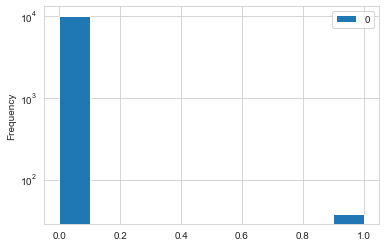

In [52]:
pd.DataFrame(dataset.reward).plot(kind='hist', logy=True)

#### position and reward interaction

from plots its evident that reward is dependent on the position
the left (id=0) and center (id=1) has higher reward than the right position (id=2)
Henceforth off policy estimators with combinitorial/slate action space should perform better

In [100]:
# ZOZOTOWN recommendation interface has three positions
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset.len_list

3

In [87]:
# position in data
# 1 - 3
pd.DataFrame(dataset.data.position).describe()

,position
count,10000.000000
mean,1.994400
std,0.811686
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,3.000000


In [88]:
# preprocessed position
# 0 - 2
pd.DataFrame(dataset.position).describe()

,0
count,10000.000000
mean,0.994400
std,0.811686
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


<AxesSubplot:ylabel='Frequency'>

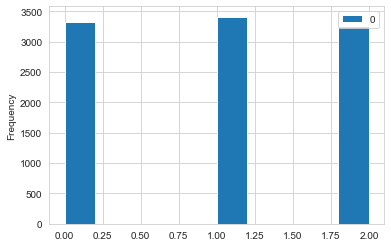

In [66]:
# position is equally distributed
pd.DataFrame(dataset.position).plot(kind='hist')

<AxesSubplot:>

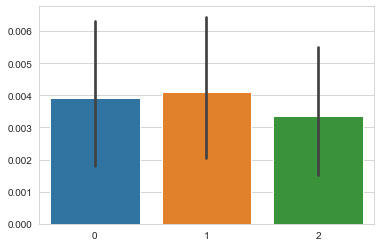

In [78]:
import seaborn as sns

sns.barplot(x = dataset.position, y=dataset.reward)

#### probability / propensity score

random policy => 1/80 chance to pick any arm

In [79]:
type(dataset.pscore), len(dataset.pscore)

(numpy.ndarray, 10000)

In [85]:
1/dataset.n_actions

0.0125

In [80]:
dataset.pscore[:5]

array([0.0125, 0.0125, 0.0125, 0.0125, 0.0125])

<AxesSubplot:>

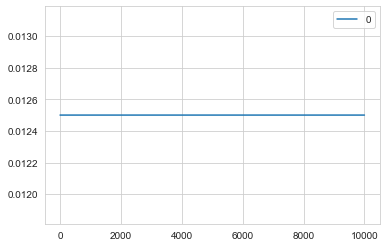

In [86]:
pd.DataFrame(dataset.pscore).plot()

#### User Features / context

features are hashed to preserve privacy of the users
these features contains user demographic details such as age, gender, location etc.

In [92]:
user_cols = dataset.data.columns.str.contains("user_feature")

In [93]:
dataset.data.loc[:, user_cols].head()

,user_feature_0,user_feature_1,user_feature_2,user_feature_3
0,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85
1,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8
2,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,270b3e1c052b4f2e9c90bf0ebeb84f34
3,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8
4,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,f97571b9c14a786aab269f0b427d2a85


In [94]:
dataset.data.loc[:, user_cols].describe(include='all')

,user_feature_0,user_feature_1,user_feature_2,user_feature_3
count,10000,10000,10000,10000
unique,3,5,8,8
top,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,9bde591ffaab8d54c457448e4dca6f53
freq,8200,8308,2437,3681


In [95]:
# total unique user features
3 + 5 + 8 + 8

24

##### `context` is the one-hot encoded matrix from `user_features (0 to 3)` in raw data

In [104]:
dataset.dim_context

20

In [105]:
type(dataset.context), dataset.context.shape

(numpy.ndarray, (10000, 20))

In [106]:
dataset.context[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]],
      dtype=uint8)

#### timestamp

data collection range: 2019-11-24 to 2019-12-01

time range is low, henceforth weighting reward on time might not be useful!

In [120]:
dataset.data.timestamp[:5]

0    2019-11-24 00:00:34.762830+00:00
1    2019-11-24 00:00:53.965051+00:00
2    2019-11-24 00:00:56.727734+00:00
3    2019-11-24 00:02:17.189232+00:00
4    2019-11-24 00:03:02.129117+00:00
Name: timestamp, dtype: object

In [139]:
pd.to_datetime(dataset.data.timestamp).dtypes

datetime64[ns, UTC]

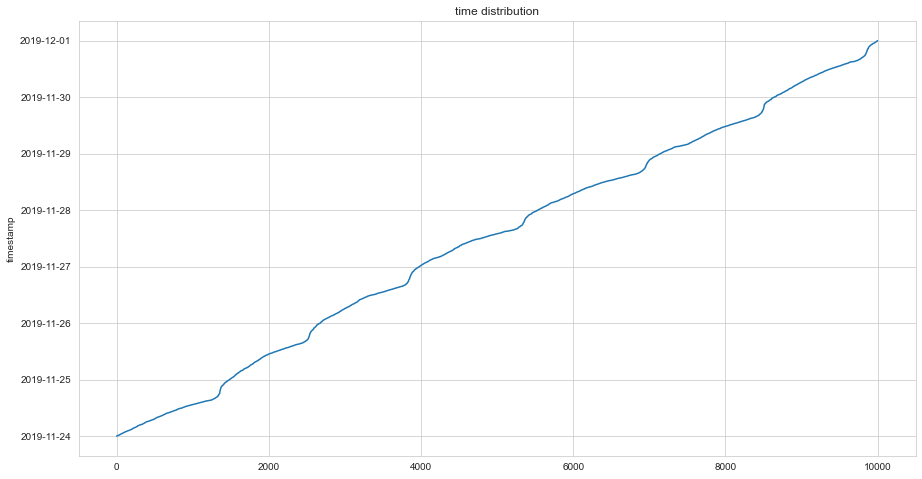

In [138]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
plt.title("time distribution")
sns.lineplot(data=pd.to_datetime(dataset.data.timestamp))
plt.show()

#### Item-id

TODO:
- item-id over time-steps
- item-id over positions



In [141]:
dataset.data.item_id.describe()

count    10000.000000
mean        39.287000
std         23.163931
min          0.000000
25%         19.000000
50%         40.000000
75%         59.000000
max         79.000000
Name: item_id, dtype: float64

#### Plot Action Distribution for both Random and BerTS logging policies

can display for different campaigns => all, men, women

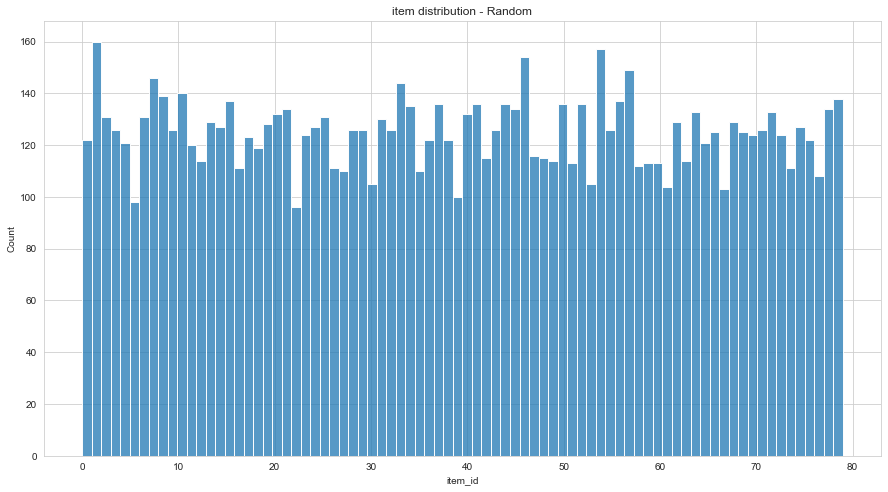

In [176]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
plt.title("item distribution - Random")
sns.histplot(x=dataset.data.item_id, bins=80)
plt.show()

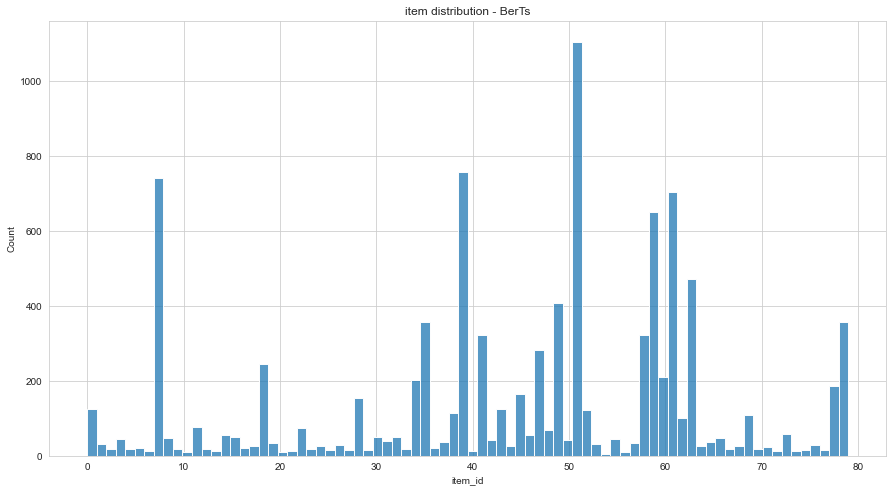

In [175]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
plt.title("item distribution - BerTs")
sns.histplot(x=dataset_bts_all.data.item_id, bins=80)
plt.show()

#### Item / Action Context

item_feature_0 => continuous feature

item_feature_(1-3) => categorical feature - hashed

In [98]:
dataset.item_context.head()

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,0,-0.499172,aed790911d0344f149be2fb9470d6f0a,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
1,1,-0.543775,31af389431e50a8fcd6470aeeb7951f8,67503f4af781d4037a8bac5e22549edd,5c1e29f902c3ad66e0ff9f6020b1aa0b
2,2,0.972752,31af389431e50a8fcd6470aeeb7951f8,84da86f2aa5e816a473e4065f137bfa9,1ead5eb1766472d5bbe45ef0d5654a59
3,3,-0.521473,62dc7dd3bfeff6123b2f6f243da49a17,baf3941793166b612fd495e7ee5f9111,f56faf88e4759846197592d0216dd55b
4,4,1.909430,e2d1f9aa026708d54e048afce24cd2fe,1c267fe1a67f13b0417f8cf83c79cd7a,1ead5eb1766472d5bbe45ef0d5654a59


In [145]:
type(dataset.item_context)

pandas.core.frame.DataFrame

In [75]:
dataset.item_context.describe(include='all')

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
count,80.0000,8.000000e+01,80,80,80
unique,NaN,NaN,12,21,7
top,NaN,NaN,aed790911d0344f149be2fb9470d6f0a,67503f4af781d4037a8bac5e22549edd,f56faf88e4759846197592d0216dd55b
freq,NaN,NaN,14,11,27
mean,39.5000,-1.276756e-16,NaN,NaN,NaN
std,23.2379,1.006309e+00,NaN,NaN,NaN
min,0.0000,-1.056718e+00,NaN,NaN,NaN
25%,19.7500,-6.218319e-01,NaN,NaN,NaN
50%,39.5000,-4.322660e-01,NaN,NaN,NaN
75%,59.2500,3.482995e-01,NaN,NaN,NaN


##### `action_context` is derived from `item_context` column in raw dataframe
and contains label-encoded categorical features `item_feature (1 to 3)` and numerical feature `item_feature0`

In [147]:
type(dataset.action_context), len(dataset.action_context)

(numpy.ndarray, 80)

In [148]:
dataset.action_context[:5]

array([[ 5.        , 10.        ,  4.        , -0.49917163],
       [ 1.        , 10.        ,  4.        , -0.54377537],
       [ 1.        , 12.        ,  1.        ,  0.97275186],
       [ 2.        , 15.        ,  6.        , -0.5214735 ],
       [10.        ,  1.        ,  1.        ,  1.90943043]])

In [149]:
pd.DataFrame(dataset.action_context).describe(include='all')

,0,1,2,3
count,80.000000,80.00000,80.000000,8.000000e+01
mean,4.412500,11.42500,3.712500,-1.276756e-16
std,3.212687,5.96355,2.200079,1.006309e+00
min,0.000000,0.00000,0.000000,-1.056718e+00
25%,2.000000,6.00000,1.000000,-6.218319e-01
50%,4.000000,12.00000,4.000000,-4.322660e-01
75%,7.000000,17.00000,6.000000,3.482995e-01
max,11.000000,20.00000,6.000000,3.782788e+00


#### User Item Affinity

**Definition:**
- user-item affinity scores induced by the number of past clicks observed between each user-item pair.
- can be greater than 1

**Understanding for Random Dataset:**
- checked for user-item_affinity => 1,2,3,4,5,52
- couldn't find any example where item/action with affinity-score=1 is selected!
- because the dataset is random

**Understanding for BerTS Dataset:**
- checked for user-item_affinity => 5
- couldn't find any example where item/action with affinity-score=1 is selected!


**Analysis required to understand correlation between user-item-affinity, selected-item and clicks!**



In [150]:
dataset.data.columns

Index(['timestamp', 'item_id', 'position', 'click', 'propensity_score',
       'user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3',
       'user-item_affinity_0', 'user-item_affinity_1', 'user-item_affinity_2',
       'user-item_affinity_3', 'user-item_affinity_4', 'user-item_affinity_5',
       'user-item_affinity_6', 'user-item_affinity_7', 'user-item_affinity_8',
       'user-item_affinity_9', 'user-item_affinity_10',
       'user-item_affinity_11', 'user-item_affinity_12',
       'user-item_affinity_13', 'user-item_affinity_14',
       'user-item_affinity_15', 'user-item_affinity_16',
       'user-item_affinity_17', 'user-item_affinity_18',
       'user-item_affinity_19', 'user-item_affinity_20',
       'user-item_affinity_21', 'user-item_affinity_22',
       'user-item_affinity_23', 'user-item_affinity_24',
       'user-item_affinity_25', 'user-item_affinity_26',
       'user-item_affinity_27', 'user-item_affinity_28',
       'user-item_affinity_29', 'user-item_

In [151]:
user_item_affinity_cols = dataset.data.columns.str.contains("user-item_affinity")

In [152]:
dataset.data.loc[:, user_item_affinity_cols].head()

,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
dataset.data.loc[:, user_item_affinity_cols].describe(include='all', percentiles=[0.75, 0.99, 0.995, 0.9999])

,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
count,10000.0000,10000.000000,10000.0000,10000.0,10000.0000,10000.000000,10000.000000,10000.000000,10000.0000,10000.0000,...,10000.000000,10000.000000,10000.000000,10000.0,10000.0000,10000.0000,10000.0,10000.0,10000.0000,10000.00000
mean,0.0001,0.000200,0.0001,0.0,0.0001,0.004300,0.000400,0.000300,0.0001,0.0001,...,0.000500,0.003000,0.000200,0.0,0.0001,0.0001,0.0,0.0,0.0001,0.00070
std,0.0100,0.014141,0.0100,0.0,0.0100,0.066947,0.019997,0.017319,0.0100,0.0100,...,0.022356,0.059928,0.014141,0.0,0.0100,0.0100,0.0,0.0,0.0100,0.02645
min,0.0000,0.000000,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.00000
50%,0.0000,0.000000,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.00000
75%,0.0000,0.000000,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.00000
99%,0.0000,0.000000,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.00000
99.5%,0.0000,0.000000,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.00000
99.99%,0.0001,1.000000,0.0001,0.0,0.0001,1.000100,1.000000,1.000000,0.0001,0.0001,...,1.000000,2.000000,1.000000,0.0,0.0001,0.0001,0.0,0.0,0.0001,1.00000
max,1.0000,1.000000,1.0000,0.0,1.0000,2.000000,1.000000,1.000000,1.0000,1.0000,...,1.000000,2.000000,1.000000,0.0,1.0000,1.0000,0.0,0.0,1.0000,1.00000


In [167]:
dataset.data[dataset.data['user-item_affinity_5'] != 0]

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
125,2019-11-24 01:56:59.978675+00:00,51,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,2019-11-24 08:33:38.667529+00:00,38,1,1,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,2019-11-24 09:50:45.589584+00:00,45,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
868,2019-11-24 12:04:35.448832+00:00,30,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,7bc94a2da491829b777c49c4b5e480f2,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
881,2019-11-24 12:14:34.808523+00:00,17,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1068,2019-11-24 13:57:16.269236+00:00,38,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,06128286bcc64b6a4b0fb7bc0328fe17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1107,2019-11-24 14:17:14.017350+00:00,54,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,f1c2d6a32ec39249160cf784b63f4c6f,2723d2eb8bba04e0362098011fa3997b,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1264,2019-11-24 15:34:34.754613+00:00,33,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1800,2019-11-25 06:59:30.459636+00:00,36,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2619,2019-11-25 22:36:13.001781+00:00,8,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### BerTs

In [177]:
user_item_affinity_cols = dataset.data.columns.str.contains("user-item_affinity")

In [178]:
dataset_bts_all.data.loc[:, user_item_affinity_cols].head()

,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
dataset_bts_all.data.loc[:, user_item_affinity_cols].describe(include='all', percentiles=[0.75, 0.99, 0.995, 0.9999])

,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
count,10000.0,10000.0000,10000.0000,10000.0,10000.0,10000.000000,10000.000000,10000.000000,10000.0000,10000.0,...,10000.00000,10000.000000,10000.000000,10000.0000,10000.000000,10000.0000,10000.0,10000.000000,10000.0,10000.000000
mean,0.0,0.0001,0.0001,0.0,0.0,0.004700,0.000600,0.000200,0.0001,0.0,...,0.00070,0.003400,0.000400,0.0001,0.000300,0.0001,0.0,0.000300,0.0,0.000400
std,0.0,0.0100,0.0100,0.0,0.0,0.076671,0.024489,0.014141,0.0100,0.0,...,0.02645,0.061553,0.019997,0.0100,0.017319,0.0100,0.0,0.017319,0.0,0.019997
min,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000
50%,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000
75%,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000
99%,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000
99.5%,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.00000,0.000000,0.000000,0.0000,0.000000,0.0000,0.0,0.000000,0.0,0.000000
99.99%,0.0,0.0001,0.0001,0.0,0.0,2.000100,1.000000,1.000000,0.0001,0.0,...,1.00000,2.000000,1.000000,0.0001,1.000000,0.0001,0.0,1.000000,0.0,1.000000
max,0.0,1.0000,1.0000,0.0,0.0,3.000000,1.000000,1.000000,1.0000,0.0,...,1.00000,2.000000,1.000000,1.0000,1.000000,1.0000,0.0,1.000000,0.0,1.000000


In [180]:
dataset_bts_all.data[dataset_bts_all.data['user-item_affinity_5'] != 0]

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
123,2019-11-24 01:46:22.033796+00:00,61,3,0,0.215650,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,f97571b9c14a786aab269f0b427d2a85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379,2019-11-24 05:57:21.506020+00:00,51,2,0,0.046690,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
441,2019-11-24 06:50:40.098016+00:00,59,2,0,0.072200,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,2019-11-24 12:17:13.492901+00:00,1,1,0,0.000670,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,7bc94a2da491829b777c49c4b5e480f2,06128286bcc64b6a4b0fb7bc0328fe17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1064,2019-11-24 13:46:26.282033+00:00,0,1,0,0.082020,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,7bc94a2da491829b777c49c4b5e480f2,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1077,2019-11-24 13:53:09.801100+00:00,63,3,0,0.097635,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1138,2019-11-24 14:17:12.565004+00:00,63,3,0,0.108510,81ce123cbb5bd8ce818f60fb3586bba5,2d03db5543b14483e52d761760686b64,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1211,2019-11-24 15:01:18.593513+00:00,0,1,0,0.278625,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1382,2019-11-24 18:23:43.083603+00:00,63,1,0,0.050365,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,06128286bcc64b6a4b0fb7bc0328fe17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1491,2019-11-24 23:27:30.636179+00:00,78,3,0,0.010445,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,9b2d331c329ceb74d3dcfb48d8798c78,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Properties

In [181]:
# Size of the logged bandit data
dataset.n_rounds

10000

In [182]:
# number of actions
dataset.n_actions

80

In [186]:
# Dimensions of context vectors
# one-hot encoded matrix of user-context columns
dataset.dim_context

20

In [188]:
# Length of recommendation lists, slate size
# left, right and center
dataset.len_list

3

### obtain_batch_bandit_feedback

the logged bandit dataset is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}$  where $(x,a,r) \sim p(x)\pi_b(a | x)p(r | x,a) $

In [190]:
# obtain logged bandit feedback generated by behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback()

In [191]:
type(bandit_feedback)

dict

In [192]:
# `bandit_feedback` is a dictionary storing logged bandit feedback
bandit_feedback.keys()

dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

In [193]:
bandit_feedback

{'n_rounds': 10000,
 'n_actions': 80,
 'action': array([14, 14, 27, ..., 32, 13, 47]),
 'position': array([2, 2, 2, ..., 2, 1, 0]),
 'reward': array([0, 0, 0, ..., 0, 0, 0]),
 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]),
 'context': array([[1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 1],
        [1, 0, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]], dtype=uint8),
 'action_context': array([[ 5.00000000e+00,  1.00000000e+01,  4.00000000e+00,
         -4.99171626e-01],
        [ 1.00000000e+00,  1.00000000e+01,  4.00000000e+00,
         -5.43775368e-01],
        [ 1.00000000e+00,  1.20000000e+01,  1.00000000e+00,
          9.72751855e-01],
        [ 2.00000000e+00,  1.50000000e+01,  6.00000000e+00,
         -5.21473497e-01],
        [ 1.00000000e+01,  1.00000000e+00,  1.00000000e+00,
          1.90943043e+00],
        [ 2.00000000e+00,  1.00000000e+01,  4.00000000e+00,
  

### let's see some properties of the dataset class

In [194]:
# name of the dataset is 'obd' (open bandit dataset)
dataset.dataset_name

'obd'

In [195]:
# number of actions of the "All" campaign is 80
dataset.n_actions

80

In [196]:
# small sample example data has 10,000 samples (or rounds)
dataset.n_rounds

10000

In [197]:
# default context (feature) engineering creates context vector with 20 dimensions
dataset.dim_context

20

In [198]:
# ZOZOTOWN recommendation interface has three positions
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset.len_list

3

## (2) Replicating Production Policy

After preparing the dataset, we now replicate the BernoulliTS policy implemented on the ZOZOTOWN recommendation interface during the data collection period.

Here, we use `obp.policy.BernoulliTS` as an evaluation policy. 
By activating its `is_zozotown_prior` argument, we can replicate (the policy parameters of) BernoulliTS used in the ZOZOTOWN production.

(When `is_zozotown_prior=False`, non-informative prior distribution is used.)

**Note: BernoulliTs is not a contextual bandit (context free),
so it don't require context (such as User-Context, Action-Context, User-Action-Affinity)**

In [199]:
# define BernoulliTS as an evaluation policy
evaluation_policy = BernoulliTS(
    n_actions=dataset.n_actions, 
    len_list=dataset.len_list,
    is_zozotown_prior=True, # replicate the BernoulliTS policy in the ZOZOTOWN production
    campaign="all",
    random_state=12345,
)

In [200]:
evaluation_policy

BernoulliTS(n_actions=80, len_list=3, batch_size=1, random_state=12345, alpha=[47.0, 8.0, 62.0, 142.0, 3.0, 14.0, 7.0, 857.0, 12.0, 15.0, 6.0, 100.0, 48.0, 23.0, 71.0, 61.0, 13.0, 16.0, 518.0, 30.0, 7.0, 4.0, 23.0, 8.0, 10.0, 11.0, 11.0, 18.0, 121.0, 11.0, 11.0, 10.0, 14.0, 9.0, 204.0, 58.0, 3.0, 19.0, 42.0, 1013.0, 2.0, 328.0, 15.0, 31.0, 14.0, 138.0, 45.0, 55.0, 23.0, 38.0, 10.0, 401.0, 52.0, 6.0, 3.0, 6.0, 5.0, 32.0, 35.0, 133.0, 52.0, 820.0, 43.0, 195.0, 8.0, 42.0, 40.0, 4.0, 32.0, 30.0, 9.0, 22.0, 6.0, 23.0, 5.0, 54.0, 8.0, 22.0, 65.0, 246.0], beta=[12198.0, 3566.0, 15993.0, 35522.0, 2367.0, 4609.0, 3171.0, 181745.0, 4372.0, 4951.0, 3100.0, 24665.0, 13210.0, 7061.0, 18061.0, 17449.0, 5644.0, 6787.0, 111326.0, 8776.0, 3334.0, 2271.0, 7389.0, 2659.0, 3665.0, 4724.0, 3561.0, 5085.0, 27407.0, 4601.0, 4756.0, 4120.0, 4736.0, 3788.0, 45292.0, 14719.0, 2189.0, 5589.0, 11995.0, 222255.0, 2308.0, 70034.0, 4801.0, 8274.0, 5421.0, 31912.0, 12213.0, 13576.0, 6230.0, 10382.0, 4141.0, 85731.0, 

In [206]:
# compute the `action choice probabilities` of the `evaluation policy` via `Monte Carlo simulation`
# representing the distribution over actions by the evaluation policy
# Probability estimates of each arm being the best one for each sample, action, and position

action_dist = evaluation_policy.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback["n_rounds"],
)

In [207]:
# `action_dist` is an array of shape (n_rounds, n_actions, len_list)
# Probability estimates of each arm being the best one for each sample, action, and position
action_dist.shape

(10000, 80, 3)

In [210]:
action_dist[6].T

array([[1.0710e-02, 1.6600e-03, 5.3900e-03, 6.1000e-04, 3.0000e-04,
        8.9200e-03, 2.3800e-03, 7.8300e-03, 4.4600e-03, 7.1700e-03,
        1.0300e-03, 4.0300e-03, 3.3200e-03, 4.9300e-03, 4.8200e-03,
        2.9000e-04, 1.8000e-04, 4.0000e-05, 9.2600e-03, 4.7800e-03,
        1.4500e-03, 2.2900e-03, 2.4700e-03, 2.9410e-02, 6.6200e-03,
        7.0000e-04, 1.8950e-02, 2.7530e-02, 2.4910e-02, 1.0300e-03,
        4.5000e-04, 2.0200e-03, 5.7900e-03, 2.0500e-03, 1.6790e-02,
        9.8800e-03, 7.7000e-04, 1.5770e-02, 2.3800e-03, 3.6000e-04,
        8.0000e-05, 2.7350e-02, 1.0190e-02, 1.8160e-02, 9.9000e-04,
        1.0720e-02, 5.1000e-03, 1.8980e-02, 2.9000e-02, 7.5000e-03,
        1.7500e-03, 1.8750e-02, 2.3040e-02, 4.2700e-03, 5.2000e-04,
        4.8000e-03, 6.3000e-04, 2.3800e-03, 1.0710e-02, 9.1020e-02,
        6.0620e-02, 2.0006e-01, 2.6200e-03, 7.2920e-02, 6.2400e-03,
        4.2200e-03, 8.1700e-03, 1.8000e-04, 8.8000e-03, 5.5200e-03,
        1.0500e-03, 8.3900e-03, 7.1000e-04, 9.45

<AxesSubplot:>

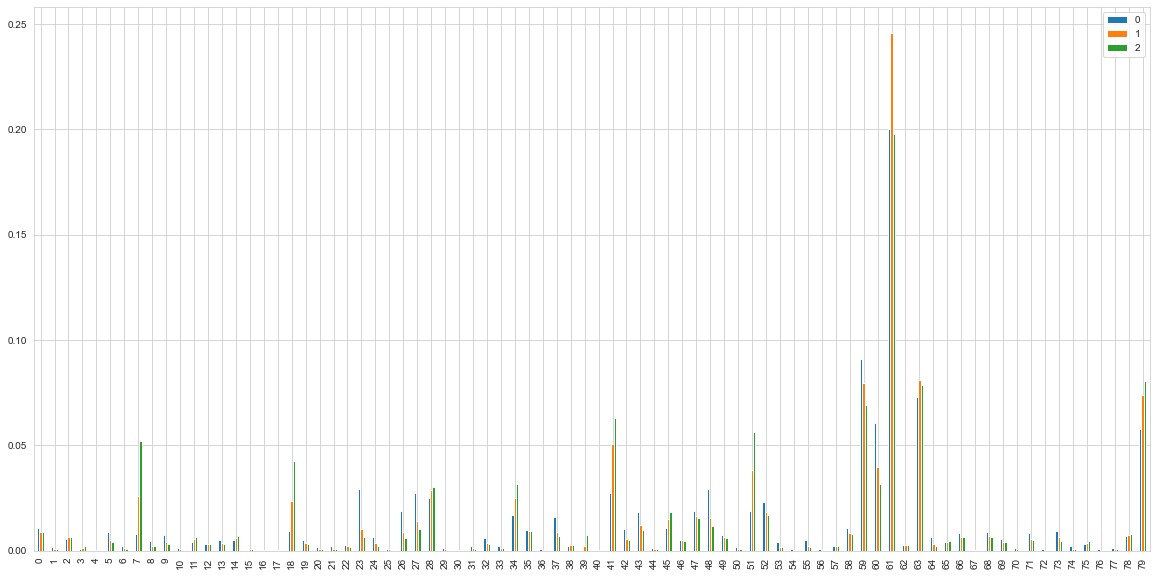

In [209]:
pd.DataFrame(action_dist[0]).plot(kind='bar', figsize=(20,10))

### Testing BerTS without Prior weights (non production)

TODO: check how to train these algorithms offline

In [211]:
# define BernoulliTS as an evaluation policy
bts_evaluation_policy = BernoulliTS(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    random_state=12345,
)

In [225]:
bts_evaluation_policy

BernoulliTS(n_actions=80, len_list=3, batch_size=1, random_state=12345, alpha=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), beta=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), is_zozotown_prior=False, campaign=None, policy_name='bts')

In [213]:
bts_action_dist = bts_evaluation_policy.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback["n_rounds"],
)

In [215]:
bts_action_dist[0].T

array([[0.01231, 0.0124 , 0.01285, 0.01239, 0.01244, 0.01206, 0.01295,
        0.0127 , 0.01227, 0.01236, 0.01324, 0.01278, 0.01329, 0.01213,
        0.0123 , 0.0123 , 0.01221, 0.01228, 0.01244, 0.01242, 0.01236,
        0.01254, 0.01185, 0.01232, 0.01263, 0.01266, 0.01245, 0.01259,
        0.01226, 0.01243, 0.01193, 0.01247, 0.01257, 0.01227, 0.01294,
        0.01254, 0.013  , 0.01267, 0.0126 , 0.0121 , 0.01262, 0.01195,
        0.0123 , 0.01253, 0.01258, 0.01268, 0.01314, 0.01275, 0.01302,
        0.01247, 0.01276, 0.01264, 0.01259, 0.01233, 0.01269, 0.01252,
        0.01299, 0.01216, 0.0126 , 0.01223, 0.0126 , 0.01249, 0.01178,
        0.01298, 0.0121 , 0.01249, 0.01252, 0.01278, 0.01265, 0.01267,
        0.01251, 0.01208, 0.0123 , 0.01217, 0.01187, 0.01253, 0.01254,
        0.01277, 0.01254, 0.01278],
       [0.01201, 0.01218, 0.0124 , 0.01234, 0.01301, 0.01287, 0.0118 ,
        0.01276, 0.0125 , 0.01263, 0.01304, 0.01213, 0.01271, 0.01212,
        0.01214, 0.01235, 0.01214, 0.0125

<AxesSubplot:>

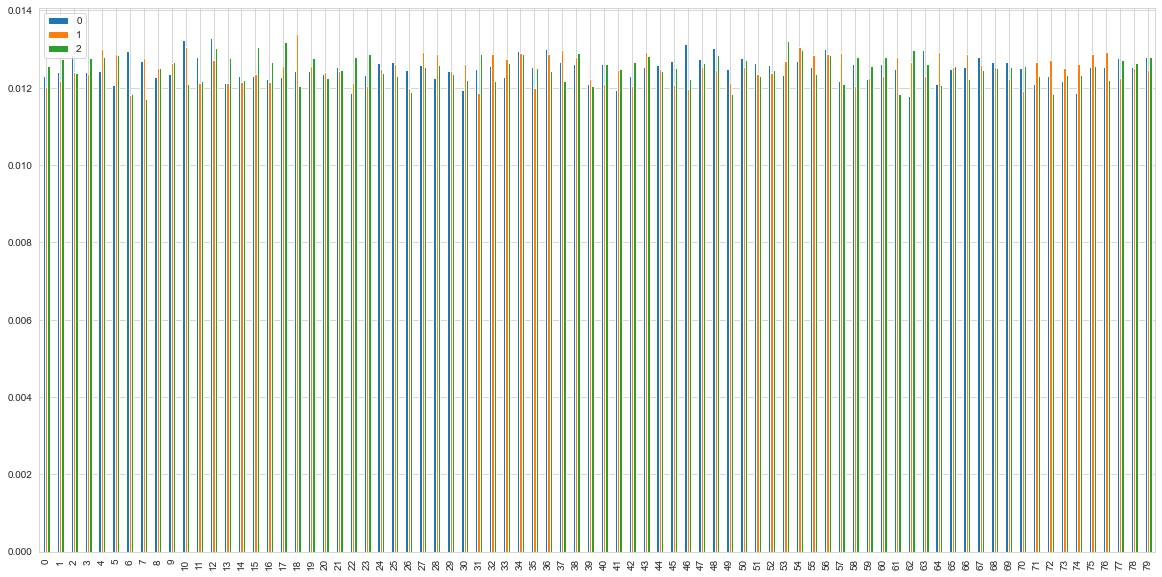

In [218]:
pd.DataFrame(bts_action_dist[150]).plot(kind='bar', figsize=(20,10))

## (3) Off-Policy Evaluation (OPE)
Our next step is OPE, which aims to estimate the performance of evaluation policies using logged bandit data and OPE estimators.

Here, we use 
- `obp.ope.InverseProbabilityWeighting` (IPW)
- `obp.ope.DirectMethod` (DM)
- `obp.ope.DoublyRobust` (DR)

as estimators and visualize the OPE results.

### (3-1) Obtaining a reward estimator
A reward estimator $\hat{q}(x,a)$ is needed for model dependent estimators such as DM or DR.

$\hat{q}(x,a) \approx \mathbb{E} [r \mid x,a]$

please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.

In [219]:
# estimate the expected rewards by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    action_context=dataset.action_context,
    base_model=LogisticRegression(max_iter=1000, random_state=12345),
)

In [220]:
regression_model

RegressionModel(base_model=LogisticRegression(max_iter=1000, random_state=12345), n_actions=80, len_list=3, action_context=array([[ 5.00000000e+00,  1.00000000e+01,  4.00000000e+00,
        -4.99171626e-01],
       [ 1.00000000e+00,  1.00000000e+01,  4.00000000e+00,
        -5.43775368e-01],
       [ 1.00000000e+00,  1.20000000e+01,  1.00000000e+00,
         9.72751855e-01],
       [ 2.00000000e+00,  1.50000000e+01,  6.00000000e+00,
        -5.21473497e-01],
       [ 1.00000000e+01,  1.00000000e+00,  1.00000000e+00,
         1.90943043e+00],
       [ 2.00000000e+00,  1.00000000e+01,  4.00000000e+00,
        -4.99171626e-01],
       [ 5.00000000e+00,  1.70000000e+01,  5.00000000e+00,
         3.48299469e-01],
       [ 8.00000000e+00,  1.00000000e+01,  4.00000000e+00,
        -2.76152917e-01],
       [ 2.00000000e+00,  1.80000000e+01,  4.00000000e+00,
        -6.55284723e-01],
       [ 5.00000000e+00,  1.40000000e+01,  0.00000000e+00,
        -3.87662271e-01],
       [ 1.00000000e+01,  1

In [221]:
# please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure

estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    position=bandit_feedback["position"],
    pscore=bandit_feedback["pscore"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

In [222]:
estimated_rewards_by_reg_model.shape

(10000, 80, 3)

In [223]:
estimated_rewards_by_reg_model[0].T

array([[0.00169361, 0.00227327, 0.00235995, 0.00181346, 0.00163354,
        0.002114  , 0.00143802, 0.0013652 , 0.00172823, 0.0016331 ,
        0.00116908, 0.00225014, 0.00128986, 0.00146729, 0.00222077,
        0.00224584, 0.00230529, 0.00161217, 0.00197877, 0.00231118,
        0.00174255, 0.00132044, 0.00164322, 0.00175829, 0.00176598,
        0.00177371, 0.00181346, 0.00244909, 0.00105831, 0.00178313,
        0.00164538, 0.00163821, 0.00197762, 0.00197762, 0.00161788,
        0.00161788, 0.00128462, 0.00123484, 0.0028702 , 0.00176379,
        0.0016331 , 0.00183888, 0.00119078, 0.00131633, 0.00162284,
        0.00101216, 0.00104784, 0.00107916, 0.00175631, 0.00198398,
        0.00212285, 0.0015545 , 0.00150174, 0.00254663, 0.00205639,
        0.00182696, 0.00205639, 0.00258586, 0.00235871, 0.00204906,
        0.00269082, 0.00170421, 0.00108607, 0.00130422, 0.00160818,
        0.00176435, 0.00141921, 0.00212723, 0.00194631, 0.00189671,
        0.00272738, 0.00200229, 0.00268579, 0.00

<AxesSubplot:>

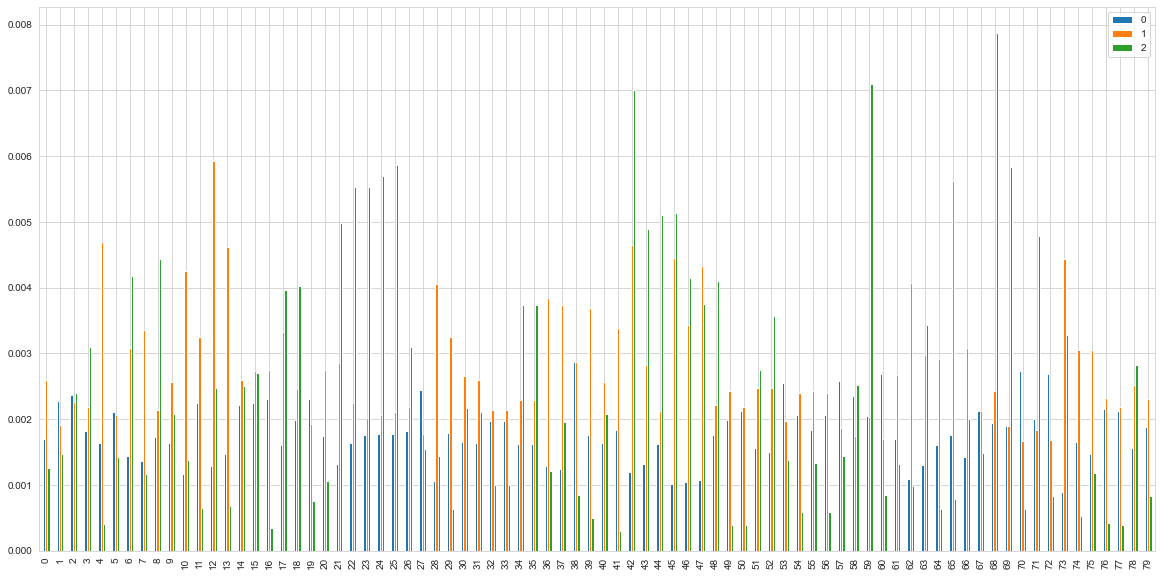

In [224]:
pd.DataFrame(estimated_rewards_by_reg_model[0]).plot(kind='bar', figsize=(20,10))

### (3-2) Off-Policy Evaluation
$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_b, \theta)$ using DM, IPW, and DR

In [226]:
# estimate the policy value of BernoulliTS based on its action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

In [227]:
type(ope)

obp.ope.meta.OffPolicyEvaluation

In [229]:
ope

OffPolicyEvaluation(bandit_feedback={'n_rounds': 10000, 'n_actions': 80, 'action': array([14, 14, 27, ..., 32, 13, 47]), 'position': array([2, 2, 2, ..., 2, 1, 0]), 'reward': array([0, 0, 0, ..., 0, 0, 0]), 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]), 'context': array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8), 'action_context': array([[ 5.00000000e+00,  1.00000000e+01,  4.00000000e+00,
        -4.99171626e-01],
       [ 1.00000000e+00,  1.00000000e+01,  4.00000000e+00,
        -5.43775368e-01],
       [ 1.00000000e+00,  1.20000000e+01,  1.00000000e+00,
         9.72751855e-01],
       [ 2.00000000e+00,  1.50000000e+01,  6.00000000e+00,
        -5.21473497e-01],
       [ 1.00000000e+01,  1.00000000e+00,  1.00000000e+00,
         1.90943043e+00],
       [ 2.00000000e+00,  1.00000000e+01,  4.000

In [230]:
# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling.
    random_state=12345,
)

In [231]:
# the estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative_estimated_policy_value is the policy value of the evaluation policy relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value

,estimated_policy_value,relative_estimated_policy_value
ipw,0.004589,1.207516
dm,0.003539,0.931366
dr,0.004766,1.254109


In [248]:
# confidence intervals of policy value of BernoulliTS estimated by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval

,mean,95.0% CI (lower),95.0% CI (upper)
ipw,0.004580,0.001531,0.009297
dm,0.003539,0.003495,0.003584
dr,0.004755,0.001715,0.009479


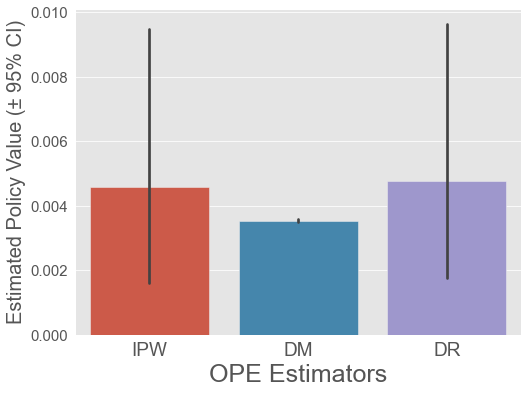

In [233]:
# visualize the estimated policy values of BernoulliTS and their 95% confidence intervals (estimated by bootstrap)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

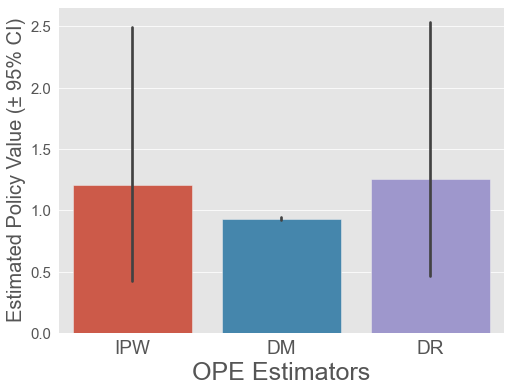

In [234]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
    is_relative=True,
    random_state=12345,
)

Note that the OPE demonstration here is with the small size example version of our dataset. 

Please use its full size version (https://research.zozo.com/data.html) to produce more reasonable results.

## (4) Evaluation of OPE

Our final step is the **evaluation of OPE**, which evaluates the estimation accuracy of OPE estimators.

Specifically, we asses the accuracy of DM, IPW, and DR by comparing their estimations with the ground-truth policy value estimated via the on-policy estimation from Open Bandit Dataset.

This type of evaluation of OPE is possible, because Open Bandit Dataset contains a set of *multiple* different logged bandit datasets collected by running different policies on the same platform at the same time.

Please refer to [the documentation](https://zr-obp.readthedocs.io/en/latest/evaluation_ope.html) for the details about the evaluation of OPE protocol.

### (4-1) Approximate the Ground-truth Policy Value 
With Open Bandit Dataset, we can estimate the ground-truth policy value of the evaluation policy in an on-policy manner as follows.

$V(\pi_e) \approx \frac{1}{|\mathcal{D}_{e}|} \sum_{i=1}^{|\mathcal{D}_{e}|} \mathbb{E}_{n} [r_i]$

$ \mathcal{D}_e := \{(x_i,a_i,r_i)\} $ ($(x,a,r) \sim p(x)\pi_e(a | x)p(r | x,a) $) is the log data collected by the evaluation policy (, which is used only for approximating the ground-truth policy value).

We can compare the policy values estimated by OPE estimators with this on-policy estimate to evaluate the accuracy of OPE.

In [241]:
# we first calculate the ground-truth policy value of the evaluation policy
# , which is estimated by averaging the factual / Empirical (observed) rewards contained in the dataset (on-policy estimation)
policy_value_bts = OpenBanditDataset.calc_on_policy_policy_value_estimate(
    behavior_policy='bts', campaign='all'
)

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


In [242]:
policy_value_bts

0.0042

In [243]:
# other way - using raw data

dataset_bts_all.obtain_batch_bandit_feedback()["reward"].mean()

0.0042

### (4-2) Evaluation of OPE

We can evaluate the estimation performance of OPE estimators by comparing the estimated policy values of the evaluation with its ground-truth as follows.

- $\textit{relative-ee} (\hat{V}; \mathcal{D}_b) := \left| \frac{V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b)}{V(\pi_e)} \right|$ (relative estimation error; relative-ee)
- $\textit{SE} (\hat{V}; \mathcal{D}_b) := \left( V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b) \right)^2$ (squared error; se)


**We can iterate the above process several times to get more reliable results.**
- also mentioned in paper
- or here: https://zr-obp.readthedocs.io/en/latest/evaluation_ope.html

  - the above states that we can calculate the OPE performance on multiple bootstrapped datasets to get more robust results.

In [247]:
# evaluate the estimation performance of the OPE estimators 
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performance of given estimators

relative_ee = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_bts,
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee

,relative-ee
ipw,0.092514
dm,0.157335
dr,0.134670


In [246]:
type(relative_ee)

pandas.core.frame.DataFrame

In [245]:
se = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_bts,
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="se", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
se

,se
ipw,1.509789e-07
dm,4.366666e-07
dr,3.199195e-07


In [249]:
ope.evaluate_performance_of_estimators(
    ground_truth_policy_value=policy_value_bts,
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

{'ipw': 0.09251428571428562,
 'dm': 0.15733512371309463,
 'dr': 0.1346700663998085}

#### Trying `visualize_off_policy_estimates_of_multiple_policies`

- this method only works with 2 OPE methodologies

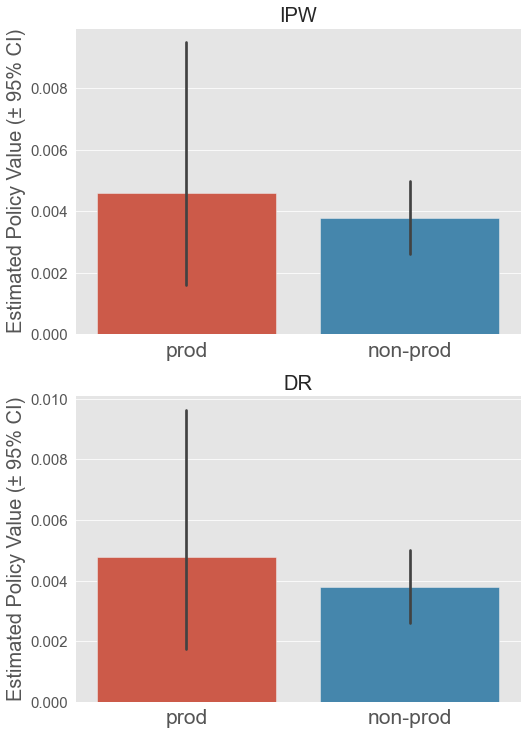

In [254]:
ope1 = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[InverseProbabilityWeighting(), DoublyRobust()]
)

ope1.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["prod", "non-prod"],
    action_dist_list=[action_dist, bts_action_dist],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000,
    random_state=12345,
)


# (
#     action_dist=action_dist,
#     estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
#     n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
#     random_state=12345,
# )

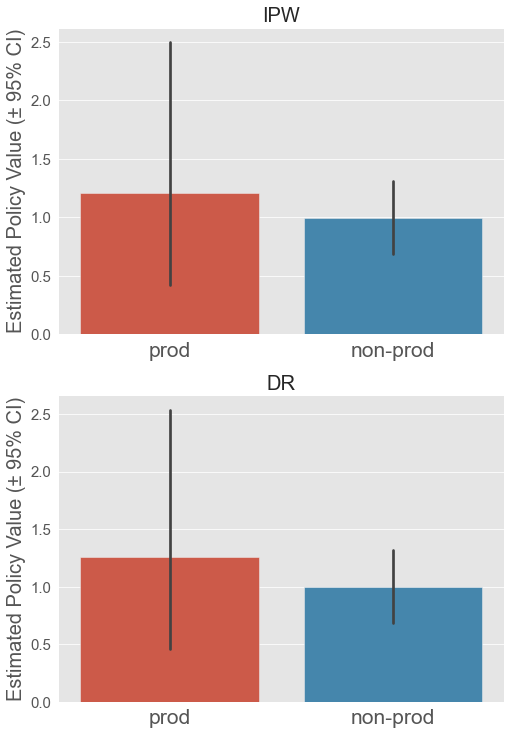

In [255]:
ope1.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["prod", "non-prod"],
    action_dist_list=[action_dist, bts_action_dist],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000,
    random_state=12345,
    is_relative=True
)



Please see [examples/obd](../obd) for a more sophisticated example of the evaluation of OPE with the Open Bandit Dataset.

## (5) Slate Off-Policy Evaluation (S-OPE)
Our next step is OPE, which aims to estimate the performance of evaluation policies using logged bandit data and OPE estimators.

Here, we use
- `SlateStandardIPS` (SIPS)
- `SlateIndependentIPS` (IIPS)
- `SlateRewardInteractionIPS` (RIPS)

and visualize the OPE results.

In [256]:
from obp.ope import SlateStandardIPS, SlateIndependentIPS, SlateRewardInteractionIPS, SlateOffPolicyEvaluation

In [257]:
dataset.len_list

3

In [258]:
bandit_feedback

{'n_rounds': 10000,
 'n_actions': 80,
 'action': array([14, 14, 27, ..., 32, 13, 47]),
 'position': array([2, 2, 2, ..., 2, 1, 0]),
 'reward': array([0, 0, 0, ..., 0, 0, 0]),
 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]),
 'context': array([[1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 1],
        [1, 0, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]], dtype=uint8),
 'action_context': array([[ 5.00000000e+00,  1.00000000e+01,  4.00000000e+00,
         -4.99171626e-01],
        [ 1.00000000e+00,  1.00000000e+01,  4.00000000e+00,
         -5.43775368e-01],
        [ 1.00000000e+00,  1.20000000e+01,  1.00000000e+00,
          9.72751855e-01],
        [ 2.00000000e+00,  1.50000000e+01,  6.00000000e+00,
         -5.21473497e-01],
        [ 1.00000000e+01,  1.00000000e+00,  1.00000000e+00,
          1.90943043e+00],
        [ 2.00000000e+00,  1.00000000e+01,  4.00000000e+00,
  

In [259]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument

sips = SlateStandardIPS(len_list=dataset.len_list)
iips = SlateIndependentIPS(len_list=dataset.len_list)
rips = SlateRewardInteractionIPS(len_list=dataset.len_list)

ope = SlateOffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[sips, iips, rips]
)

RuntimeError: Missing key of slate_id in 'bandit_feedback'.

In [274]:
import numpy as np
ar1 = np.arange(0, 3333)
ar3 = np.sort(np.concatenate([ar1, ar1, ar1, [3333]]))
ar3

array([   0,    0,    0, ..., 3332, 3332, 3333])

In [275]:
type(ar3)

numpy.ndarray

In [276]:
bandit_feedback['slate_id'] = ar3

In [278]:
bandit_feedback

{'n_rounds': 10000,
 'n_actions': 80,
 'action': array([14, 14, 27, ..., 32, 13, 47]),
 'position': array([2, 2, 2, ..., 2, 1, 0]),
 'reward': array([0, 0, 0, ..., 0, 0, 0]),
 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]),
 'context': array([[1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 1],
        [1, 0, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]], dtype=uint8),
 'action_context': array([[ 5.00000000e+00,  1.00000000e+01,  4.00000000e+00,
         -4.99171626e-01],
        [ 1.00000000e+00,  1.00000000e+01,  4.00000000e+00,
         -5.43775368e-01],
        [ 1.00000000e+00,  1.20000000e+01,  1.00000000e+00,
          9.72751855e-01],
        [ 2.00000000e+00,  1.50000000e+01,  6.00000000e+00,
         -5.21473497e-01],
        [ 1.00000000e+01,  1.00000000e+00,  1.00000000e+00,
          1.90943043e+00],
        [ 2.00000000e+00,  1.00000000e+01,  4.00000000e+00,
  

In [279]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument

# sips = SlateStandardIPS(len_list=dataset.len_list)
iips = SlateIndependentIPS(len_list=dataset.len_list)
rips = SlateRewardInteractionIPS(len_list=dataset.len_list)

ope = SlateOffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[iips, rips]
)

In [ ]:
# # `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
# estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
#     action_dist=action_dist,
#     estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
#     n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling.
#     random_state=12345,
# )

In [ ]:
estimated_policy_value_random, estimated_interval_random = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=random_policy_pscores[0],
    evaluation_policy_pscore_item_position=random_policy_pscores[1],
    evaluation_policy_pscore_cascade=random_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000,
    random_state=dataset_with_random_behavior.random_state,
)
estimated_interval_random["policy_name"] = "random"


estimated_policy_value_random